# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import seaborn as sns
import sqlite3
import tqdm

from recsyslib.parquet import (
    upload_nrows_to_df,
    parquet_upploader,
    get_parquet_row_count
)
from recsyslib.sqlite import sqlite3_connection, read_sqlite3_dump

Проверяем окружение, создаем необходимые каталоги и файлы

In [2]:
%%time
!scripts/download_data.sh

All files are already downloaded, if you need to forcely download them, please, use the -f or --force option
CPU times: user 4.74 ms, sys: 6.87 ms, total: 11.6 ms
Wall time: 129 ms


In [2]:
input_data_path = Path('ym')
output_data_path = Path('data')
output_data_path.mkdir(exist_ok=True)

assert input_data_path.exists()
assert input_data_path.is_dir()
assert set(file.stem for file in input_data_path.glob('*.parquet')) == {"catalog_names", "interactions", "tracks"} 

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

Cтруктура данных:

 * `interactions`:
    - `user_id` — идентификатор пользователя
    - `track_id` — идентификатор музыкального трека
    - `track_seq` — номер места трека в истории пользователя
    - `started_at` — дата начала прослушивания трека

 * `tracks`:
    - `track_id` — идентификатор музыкального трека
    - `albums` —  список идентификаторов альбомов, содержащих трек
    - `artists` — список идентификаторов исполнителей трека
    - `genres` — список идентификаторов жанров, к которым принадлежит трек

 * `catalog_names`:
    - `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра)
    - `type` — тип идентификатора
    - `name` — имя (название) каталожной единицы

In [4]:
%time
tracks = pd.read_parquet(input_data_path / "tracks.parquet")
catalog_names = pd.read_parquet(input_data_path / "catalog_names.parquet")
interactions = upload_nrows_to_df(input_data_path / "interactions.parquet")

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 3.34 μs


In [5]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [6]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [7]:
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

## Количество строк

In [8]:
print(f"Кол-во строк в датасете с треками: {len(tracks):e}")

Кол-во строк в датасете с треками: 1.000000e+06


In [9]:
print(f"Кол-во строк в датасете с каталогом: {len(catalog_names):e}")

Кол-во строк в датасете с каталогом: 1.812471e+06


In [10]:
interactions_rows_count = get_parquet_row_count(input_data_path / 'interactions.parquet')
print(f"Кол-во строк в датасете со взаимодействиями: {interactions_rows_count:e}")

Кол-во строк в датасете со взаимодействиями: 2.226299e+08


## Типы данныx

In [11]:
tracks.dtypes

track_id     int64
albums      object
artists     object
genres      object
dtype: object

In [12]:
catalog_names.dtypes

id       int64
type    object
name    object
dtype: object

In [13]:
interactions.dtypes

user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

## Пропущенные значения

In [14]:
tracks.isna().sum()

track_id    0
albums      0
artists     0
genres      0
dtype: int64

In [15]:
catalog_names.isna().sum()

id      0
type    0
name    0
dtype: int64

In [16]:
%%time
sum(
    pa.Table.from_batches([chunk])
        .to_pandas()
        .isna()
        .sum()
    for chunk in parquet_upploader(input_data_path / "interactions.parquet", batch_size=100000))

CPU times: user 9.7 s, sys: 1.32 s, total: 11 s
Wall time: 8.66 s


user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

## Пустые списки и пустые строки

Пустые списки исполнителей, альбомов и жанров

In [17]:
empty_albums = tracks.albums.str.len() == 0
empty_artists = tracks.artists.str.len() == 0
empty_tracks = tracks.genres.str.len() == 0
empty_name = catalog_names.name.str.len() == 0
empty_type = catalog_names.type.str.len() == 0
print(
f"""
Пустые списки альбомов: {empty_albums.sum() / len(empty_albums) * 100.:.2}%
Пустые списки исполнителей: {empty_artists.sum() / len(empty_artists) * 100.:.2}%
Пустые списки жанров: {empty_tracks.sum() / len(empty_tracks) * 100.:.2}%
Общее количество пустых ячеек в треках: {(empty_albums + empty_artists + empty_tracks).sum() / len(empty_tracks) * 100.:.2}%
Трэки, у которых что-то из вышеперечисленного пустое: {(empty_albums | empty_tracks | empty_artists).sum() / len(empty_tracks) * 100.:.2}%
Пустые имена в каталоге: {empty_name.sum()}
Пустые жанры в каталоге: {empty_type.sum()}
""")


Пустые списки альбомов: 0.0018%
Пустые списки исполнителей: 1.5%
Пустые списки жанров: 0.37%
Общее количество пустых ячеек в треках: 1.9%
Трэки, у которых что-то из вышеперечисленного пустое: 1.9%
Пустые имена в каталоге: 0
Пустые жанры в каталоге: 0



## Повторяющиеся значения

In [ ]:
duplicated_tracks = tracks.explode("albums").explode("artists").explode("genres").duplicated().sum()
duplicated_catalog_names = catalog_names.duplicated().sum()
print(
f"""
Повторяющиеся строки в треках: {duplicated_tracks}
Повторяющиеся строки в каталоге: {duplicated_catalog_names}
""")


Повторяющиеся строки в треках: 0
Повторяющиеся строки в каталоге: 0



In [3]:
%%time
# Так как объем данных в таблице interactions при загрузке в pandas может превышать 
# (sizeof(int32) * 2 + sizeof(int16) + sizeof(datetime64[ns])) * 2.226299e+08 / 2**30 = 3.73 ГБ,
# то просто для возможности работы лучше выгрузим это в SQLite3.

interactions_dump = output_data_path / "interactions.sqlite3.dump"

if not interactions_dump.exists():
    with sqlite3.connect(interactions_dump) as db:

        db.execute(
        """

            CREATE TABLE IF NOT EXISTS interactions (
                user_id INTEGER,
                track_id INTEGER,
                track_seq SHORTINT,
                started_at DATETIME,
                PRIMARY KEY (user_id, track_id, track_seq, started_at)
            );
        """)
        db.commit()

        interactions_duplicate_count = 0
        batch_size = 100000
        for chunk in tqdm.tqdm(parquet_upploader(input_data_path / "interactions.parquet", batch_size=batch_size),
                               total=interactions_rows_count / batch_size):
            next_batch = pa.Table.from_batches([chunk]).to_pandas()
            try:
                next_batch.to_sql("interactions", db, if_exists="append", index=False)
            except sqlite3.IntegrityError as e:
                interactions_duplicate_count += 1
        
        db.execute(
        """
            CREATE INDEX IF NOT EXISTS interactions_user_id_idx ON interactions (user_id);
        """)

        db.execute(
        """
            CREATE INDEX IF NOT EXISTS interactions_track_id_idx ON interactions (track_id);
        """)

        db.execute(
        """
            CREATE INDEX IF NOT EXISTS interactions_started_at_idx ON interactions (started_at);
        """)

else:
    interactions_duplicate_count = 0

print(f"Повторяющиеся строки во взаимодействиях: {interactions_duplicate_count}")

Повторяющиеся строки во взаимодействиях: 0
CPU times: user 379 μs, sys: 138 μs, total: 517 μs
Wall time: 383 μs


## Жанры, альбомы, исполнителей и взаимосвязи между ними тоже сохраним в персистентной базе данных

In [20]:
%%time

def get_tracks_attribute(attribute_type: str) -> pd.DataFrame:
    """
    Получаем новую таблицу, которая содержит только название альбома, исполнителя или жанра
    """
    _COLUMN_NAMES = {
        "album": "albums",
        "artist": "artists",
        "genre": "genres"
    }
    column = _COLUMN_NAMES[attribute_type]
    tracks_local = tracks[[column]].explode(column).dropna().drop_duplicates().astype('int64').rename(columns={column: "id"})
    return tracks_local.merge(catalog_names[catalog_names["type"] == attribute_type][["id", "name"]], on="id").drop_duplicates()

with sqlite3_connection(interactions_dump) as db:
    for attribute_type in ["album", "artist", "genre"]:
        db.execute(f"DROP TABLE IF EXISTS {attribute_type}s")
        db.execute(f"CREATE TABLE {attribute_type}s (id INTEGER PRIMARY KEY, name TEXT)")
        get_tracks_attribute(attribute_type).to_sql(f"{attribute_type}s", db, if_exists="append", index=False)

    db.execute("DROP TABLE IF EXISTS tracks_attributes_ids")
    db.execute("CREATE TABLE tracks_attributes_ids (track_id INTEGER, attribute_id INTEGER, attribute_type TEXT, UNIQUE (attribute_type, track_id, attribute_id))")
    for attribute_type in ["album", "artist", "genre"]:
        column = f"{attribute_type}s"
        local_tracks = tracks[["track_id", column]].explode(column).rename(columns={column: "attribute_id"}).dropna()
        local_tracks["attribute_id"] = local_tracks["attribute_id"].astype('int64')
        local_tracks["attribute_type"] = attribute_type
        local_tracks.to_sql("tracks_attributes_ids", db, if_exists="append", index=False)

CPU times: user 16.4 s, sys: 2.94 s, total: 19.4 s
Wall time: 23.2 s


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

**Проблемы с данными:**
 - данные в таблице `interactions` имеют очень большой объем, что приводит к вылетам по памяти при оперировании этой таблицей в pandas
 - для 0.0018% треков отсутствуют списки альбомов
 - для 1.5% треков отсутствуют списки исполнителей
 - для 0.37% треков отсутствуют списки жанров
 - отсутствуют в явном виде пользовательские оценки
 - индексы в таблице `catalog_names` не уникальны, есть дубликаты: индексы альбомов, исполнителей и жанров образуют пересекающиеся множества
 - индексы объектов и пользователей образуют последовательности, в которых есть пропуски

 **Корректирующие действия:**
 - сохранил таблицу `interactions` в SQLite3 и создал индексы для быстрого поиска по `user_id`, `track_id` и `started_at`. T.е. переложил всю ответственность за загрузку в оперативную память и дамп на диск на SQLite3
 - до конца не ясно, является ли отсутствие альбомов, исполнителей и жанров проблемой, решил оставить как есть
 - в качестве оценки возьмем частоту встречаемости трека в истории пользователя. Считаем, что время взаимодействия пользователя с сервисом не менее 1 дня (для пользователей, у которых есть только одна запись в таблице `interactions`). Полное время взаимодействия пользователя с сервисом вычисляем так: $$\Delta t = started\_at_{last} - started\_at_{first}$$
   Тогда, если за всю историю пользователя один и тот же трек повторился `N` раз, то частота встречаемости для него в истории пользователя: $$f = \frac{N}{\Delta t}$$
   Но мы это сделаем позже, так как вначале нам нужно разделить выборку на тестовые и тренировочные данные.

 - альбомы исполнителей и жанры разнес по разным таблицам, чтобы уменьшить вероятность путанницы в дальнейшем
 - при построении матрицы взаимодействий нужно перекодировать все индексы, так как в последовательностях индексов могут быть пропуски

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [21]:
%%time
with sqlite3_connection(interactions_dump) as db:
    tracks_per_user = pd.read_sql(
        "SELECT user_id, COUNT(*) AS tracks_per_user FROM interactions GROUP BY user_id", db)
    tracks_per_mounth = pd.read_sql(
        """
            SELECT
                strftime('%Y-%m', started_at) AS mounth,
                COUNT(*) AS tracks_per_mounth
            FROM interactions GROUP BY mounth
        """, db)
    tracks_per_mounth["mounth"] = pd.to_datetime(tracks_per_mounth["mounth"], format="%Y-%m")

CPU times: user 1min 37s, sys: 13.7 s, total: 1min 50s
Wall time: 1min 51s


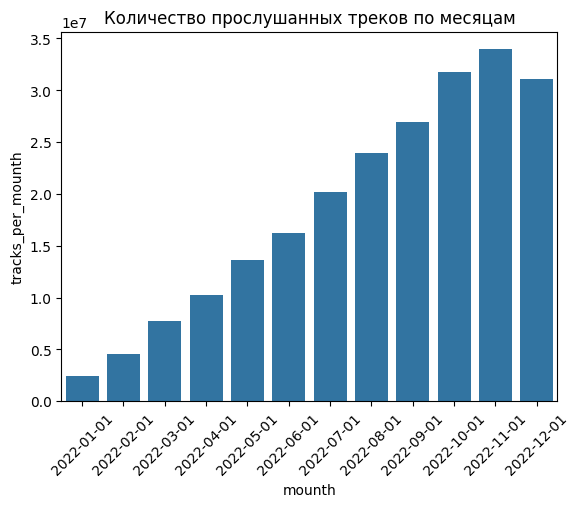

In [22]:
sns.barplot(tracks_per_mounth, x="mounth", y="tracks_per_mounth")
plt.xticks(rotation=45)
_ = plt.title("Количество прослушанных треков по месяцам")

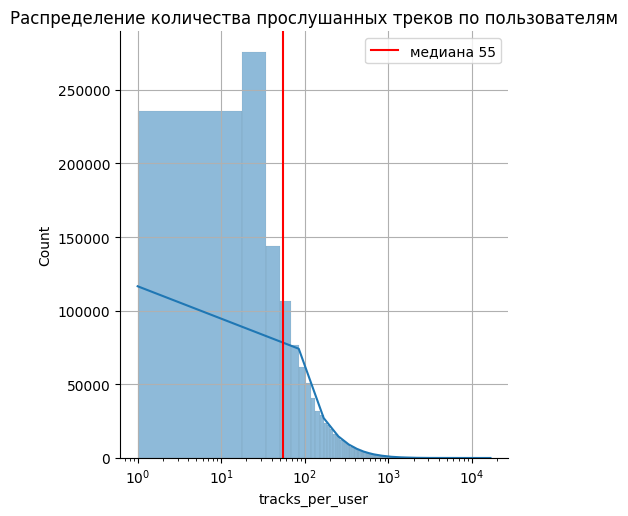

In [23]:

sns.displot(tracks_per_user['tracks_per_user'], bins=1000, kde=True)
median = tracks_per_user['tracks_per_user'].median()
plt.axvline(median, color='red', label=f'медиана {median:.0f}')
plt.xscale('log')
plt.legend()
plt.grid()
_ = plt.title('Распределение количества прослушанных треков по пользователям')

Наиболее популярные треки

In [24]:
%%time
with sqlite3_connection(interactions_dump) as db:
    tracks_popularity = pd.read_sql("""
        SELECT
            track_id,
            COUNT(*) AS popularity
        FROM interactions
        GROUP BY track_id ORDER BY popularity DESC LIMIT 50
    """, db)
    tracks_popularity = pd.merge(
        tracks_popularity,
        catalog_names,
        left_on='track_id', right_on='id', how="left")

CPU times: user 7.9 s, sys: 1.51 s, total: 9.41 s
Wall time: 9.43 s


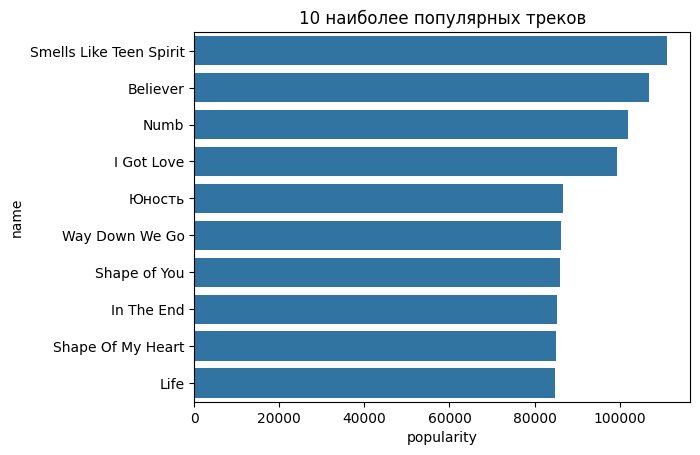

In [25]:
sns.barplot(tracks_popularity[:10], x="popularity", y="name", orient="h")
_ = plt.title("10 наиболее популярных треков")

Наиболее популярные жанры

In [26]:
%%time
with sqlite3_connection(interactions_dump) as db:
    genres_popularity = pd.read_sql("""
        WITH weights AS (
            SELECT
                aids.track_id,
                g.name AS genre_name,
                1. / (COUNT(*) OVER (PARTITION BY aids.track_id)) AS weight
            FROM tracks_attributes_ids aids
            JOIN genres g ON g.id = aids.attribute_id WHERE aids.attribute_type = 'genre'
        )
        SELECT genre_name, SUM(weight) AS popularity
        FROM weights w
        JOIN interactions i ON i.track_id = w.track_id
        GROUP BY genre_name ORDER BY popularity DESC
        LIMIT 100
    """, db)

CPU times: user 1min 51s, sys: 12.8 s, total: 2min 4s
Wall time: 2min 9s


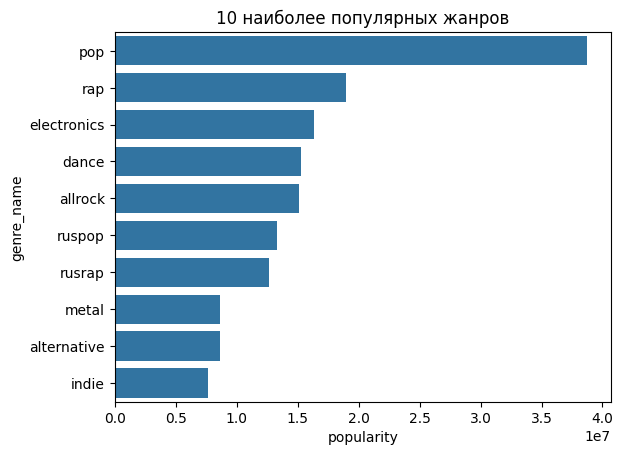

In [27]:
sns.barplot(genres_popularity[:10], x="popularity", y="genre_name", orient="h")
_ = plt.title("10 наиболее популярных жанров")

Треки, которые никто не прослушал

In [28]:
%%time
listen_tracks = read_sqlite3_dump(interactions_dump, """
    SELECT DISTINCT track_id FROM interactions
""")

CPU times: user 4.98 s, sys: 845 ms, total: 5.82 s
Wall time: 6.07 s


In [29]:
nonlisten_tracks = catalog_names[catalog_names["type"] == "track"]
nonlisten_tracks = nonlisten_tracks[~nonlisten_tracks["id"].isin(listen_tracks.track_id)]
print(f"Количество непрослушанных треков: {len(nonlisten_tracks)}")

Количество непрослушанных треков: 0


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

На данном этапе выделим интервал времени для разбиения выборок на тестовую и тренировочную части. В тестовую часть выделим последний неполный месяц - `12-2022`, а предыдущие одиннадцать месяцев используем для обучения модели.

In [5]:
%%time
split_date = pd.to_datetime("12-2022", format="%m-%Y")

with sqlite3_connection(interactions_dump) as db:
    db.execute("DROP TABLE IF EXISTS user_times")
    db.execute("""
        CREATE TABLE user_times AS
            SELECT
               user_id,
               JULIANDAY(MAX(started_at)) - JULIANDAY(MIN(started_at)) AS delta_time 
            FROM interactions WHERE started_at < ? GROUP BY user_id
    """, (str(split_date),))
    db.execute("""
        UPDATE user_times SET delta_time = 1 WHERE delta_time <= 0
    """)

    db.execute("""
        CREATE UNIQUE INDEX IF NOT EXISTS user_times_user_id_idx ON user_times (user_id)
    """)

    db.execute("DROP TABLE IF EXISTS track_ratings")
    db.execute("""
        CREATE TABLE track_ratings AS 
        SELECT
            i.user_id,
            i.track_id, 
            COUNT(*) / AVG(ut.delta_time) AS rating_count
        FROM interactions i JOIN user_times ut ON i.user_id = ut.user_id
        WHERE i.started_at < ?
        GROUP BY i.user_id, i.track_id
    """, (str(split_date),))

    db.execute("""
        CREATE UNIQUE INDEX IF NOT EXISTS track_ratings_idx ON track_ratings (user_id, track_id)
    """)


CPU times: user 3min 18s, sys: 27.2 s, total: 3min 45s
Wall time: 5min 30s


In [ ]:
events = read_sqlite3_dump(interactions_dump, """
    SELECT
        user_id,
        track_id,
        rating_count / (MAX(rating_count) OVER (PARTITION BY user_id)) as rating
    FROM track_ratings ORDER BY rating ASC LIMIT 100
""")

DatabaseError: Execution failed on sql '
    SELECT
        user_id,
        track_id,
        rating_count / (MAX(rating_count) OVER (PARTITION BY user_id)) as rating
    FROM track_ratings WHERE rating != 1.0 ORDER BY rating ASC LIMIT 100
': misuse of aliased window function rating

In [7]:
events

,user_id,track_id,rating
0,0,99262,1.0
1,0,589498,1.0
2,0,590262,1.0
3,0,590303,1.0
4,0,590692,1.0
...,...,...,...
95,3,48591644,1.0
96,3,48591706,1.0
97,3,49961817,1.0
98,3,50834580,1.0


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

# Топ популярных

Рассчитаем рекомендации как топ популярных.

# Персональные

Рассчитаем персональные рекомендации.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.